# Locality Sensitive Hashing

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
import time
from copy import copy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

In [3]:
wiki = pd.read_csv('data/people_wiki.csv')
wiki = wiki.reset_index().rename(columns={'index': 'id'})

In [4]:
wiki

,id,URI,name,text
0,0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...,...
59066,59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...
59067,59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...
59068,59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...
59069,59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...


In [5]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('data/people_wiki_tf_idf.npz')

In [6]:
assert corpus.shape == (59071, 547979)
print('Check passed correctly!')

Check passed correctly!


In [7]:
import json
with open('data/people_wiki_map_index_to_word.json', 'r') as f:
    map_index_to_word  = json.load(f)

## Train an LSH model

In [8]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [9]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print(generate_random_vectors(num_vector=3, dim=5))

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


In [10]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print(random_vectors.shape)

(547979, 16)


In [11]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print(doc.shape)
print(doc.dot(random_vectors[:, 0]) >= 0) # True if positive sign; False if negative sign

(1, 547979)
[ True]


In [12]:
print(doc.dot(random_vectors[:, 1]) >= 0 )

[ True]


In [13]:
print(doc.dot(random_vectors) >= 0) # should return an array of 16 True/False bits
print(np.array(doc.dot(random_vectors) >= 0, dtype=int)) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


In [14]:
print(corpus[0:2].dot(random_vectors) >= 0) # compute bit indices of first two documents
print(corpus.dot(random_vectors) >= 0) # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...  True False  True]
 [ True False False ... False False  True]
 [False  True False ...  True False  True]
 ...
 [ True  True False ...  True  True  True]
 [False  True  True ...  True False  True]
 [ True False  True ... False False  True]]


In [15]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print (index_bits)
print (powers_of_two)           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print (index_bits.dot(powers_of_two))

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [16]:
index_bits = corpus.dot(random_vectors) >= 0
print(index_bits.dot(powers_of_two))

[50917 36265 19365 ... 52983 27589 41449]


Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

In [17]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)

    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = []
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index)

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [18]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print('Passed!')
else:
    print('Check your code.')

Passed!


In [19]:
obama = wiki[wiki['name'] == 'Barack Obama']
id = obama.index
print(id)
   
print(np.array(model['bin_index_bits'][id], dtype=int)) # list of 0/1's
print(model['bin_indices'][id]) # integer format

Index([35817], dtype='int64')
[[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]
[50194]


In [20]:
wiki[wiki['name'] == 'Joe Biden']

,id,URI,name,text
24478,24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...


In [21]:
biden = wiki[wiki['name'] == 'Joe Biden']
id = biden.index
print (id)
   
print (np.array(model['bin_index_bits'][id], dtype=int)) # list of 0/1's
print (model['bin_indices'][id]) # integer format

Index([24478], dtype='int64')
[[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]]
[33794]


In [22]:
wiki[wiki['name']=='Wynn Normington Hugh-Jones']

,id,URI,name,text
22745,22745,<http://dbpedia.org/resource/Wynn_Normington_H...,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...


In [23]:
print (np.array(model['bin_index_bits'][22745], dtype=int) )# list of 0/1's
print (model['bin_indices'][22745] )# integer format
(model['bin_index_bits'][35817] == model['bin_index_bits'][22745]).astype(int).sum()

[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
4660


8

How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden?  Let's look at which documents are in the same bin as the Barack Obama article.

In [24]:
model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]

In [25]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.iloc[doc_ids] # filter by id column
docs

,id,URI,name,text
21426,21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

In [27]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print('================= Cosine distance from Barack Obama')
print ('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf)))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print ('Barack Obama - {0:24s}: {1:f}'.format(wiki['name'][doc_id],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf)))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


**Moral of the story**. Similar data points will in general _tend to_ fall into _nearby_ bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. **Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query.**

## Query the LSH model

Let us first implement the logic for searching nearby neighbors, which goes like this:
```
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
```

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.
```
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
```

Each line of output from the following cell is a 3-tuple indicating where the candidate bin would differ from the query bin. For instance,
```
(0, 1, 3)
```
indicates that the candiate bin differs from the query bin in first, second, and fourth bits.

In [28]:
from itertools import combinations
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print(diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [29]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = int(not alternate_bits[i])
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
            
    return candidate_set

In [31]:
#check point
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print('Passed test')
else:
    print('Check your code')
print('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


**Checkpoint**. Running the function with `search_radius=1` adds more documents to the fore.

In [32]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print ('Passed test')
else:
    print ('Check your code')

Passed test


In [33]:
def query(vec, model, max_search_radius):
      
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame({'id': list(candidate_set)})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values('distance', ascending=True)[0:10], len(candidate_set)

In [34]:
query(corpus[35817,:], model, max_search_radius=3)

(        id  distance
 369  35817  0.000000
 704  24478  0.703139
 267  56008  0.856848
 132  37199  0.874669
 515  40353  0.890034
 390   9267  0.898377
 228  55909  0.899340
 359   9165  0.900921
 229  57958  0.903003
 269  49872  0.909533,
 727)

In [35]:
id = query(corpus[35817,:], model,max_search_radius=3)[0]['id']
id

369    35817
704    24478
267    56008
132    37199
515    40353
390     9267
228    55909
359     9165
229    57958
269    49872
Name: id, dtype: int64

In [36]:
query(corpus[35817,:], model, max_search_radius=3)[0]

,id,distance
369,35817,0.000000
704,24478,0.703139
267,56008,0.856848
132,37199,0.874669
515,40353,0.890034
390,9267,0.898377
228,55909,0.899340
359,9165,0.900921
229,57958,0.903003
269,49872,0.909533


In [37]:
query(corpus[35817,:], model, max_search_radius=3)[0].merge(wiki[['id', 'name']], on='id').sort_values('distance')


,id,distance,name
0,35817,0.000000,Barack Obama
1,24478,0.703139,Joe Biden
2,56008,0.856848,Nathan Cullen
3,37199,0.874669,Barry Sullivan (lawyer)
4,40353,0.890034,Neil MacBride
5,9267,0.898377,Vikramaditya Khanna
6,55909,0.899340,Herman Cain
7,9165,0.900921,Raymond F. Clevenger
8,57958,0.903003,Michael J. Malbin
9,49872,0.909533,Lowell Barron


# Experimenting with your LSH implementation

In [38]:
wiki[wiki['name']=='Barack Obama']

,id,URI,name,text
35817,35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


In [39]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    result, num_candidates = query(corpus[35817,:], model,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    print('Radius:', max_search_radius)
    print(result.merge(wiki[['id', 'name']], on='id').sort_values('distance'))


    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
      id  distance                     name
0  35817  0.000000             Barack Obama
1  21426  0.950867            Mark Boulware
2  39426  0.975966  John Wells (politician)
3  50261  0.978256        Francis Longstaff
4  53937  0.993092    Madurai T. Srinivasan
Radius: 1
      id  distance                                   name
0  35817  0.000000                           Barack Obama
1  41631  0.947459                            Binayak Sen
2  21426  0.950867                          Mark Boulware
3  33243  0.951766                        Janice Lachance
4  33996  0.960859                            Rufus Black
5  28444  0.961081                       John Paul Phelan
6  20347  0.974130                        Gianni De Fraja
7  39426  0.975966                John Wells (politician)
8  34547  0.978215  Nathan Murphy (Australian politician)
9  50261  0.978256                      Francis Longstaff
Radius: 2
      id  distance                 name
0  35817  0.000000         B

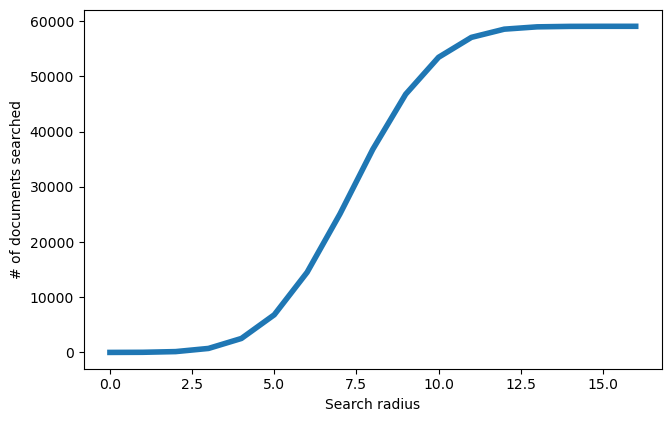

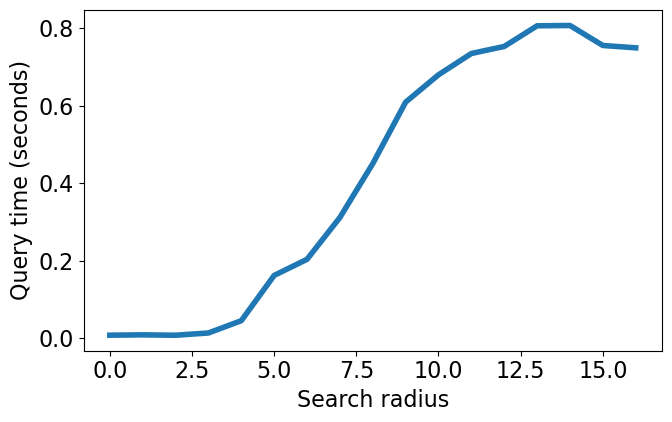

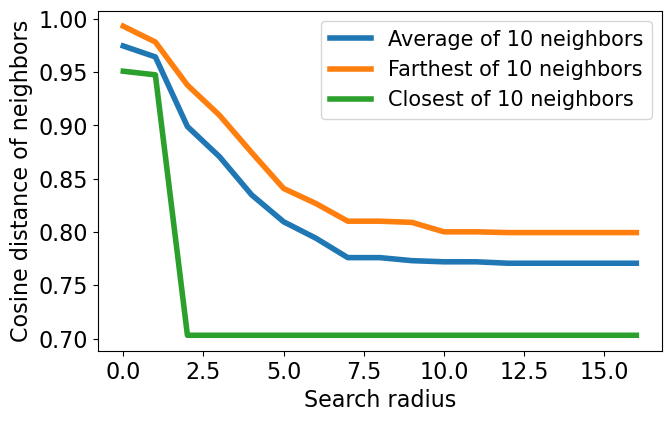

In [40]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [41]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values('distance', ascending=True)[0:k]

In [42]:
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


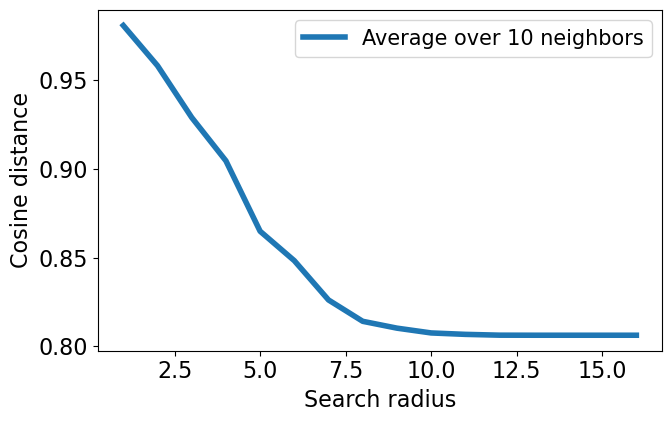

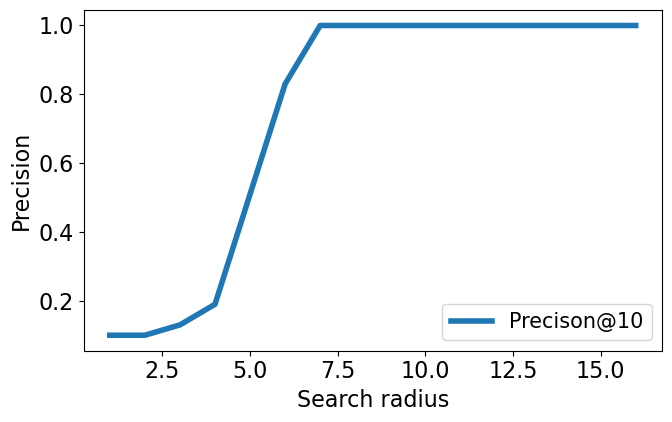

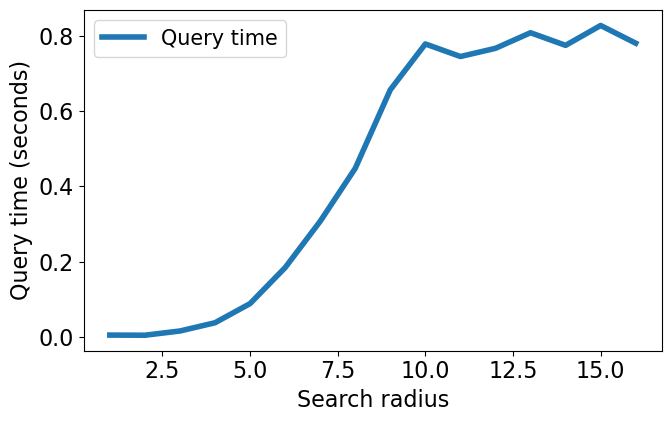

In [43]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Effect of number of random vectors

In [44]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


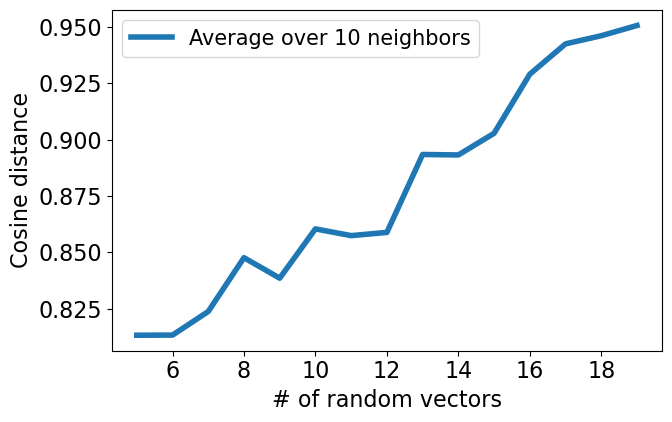

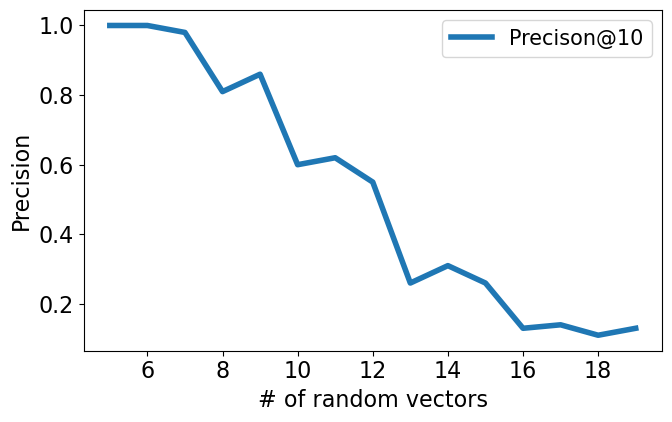

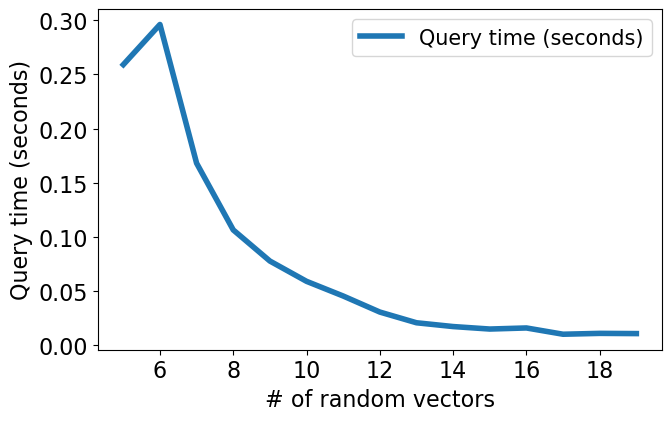

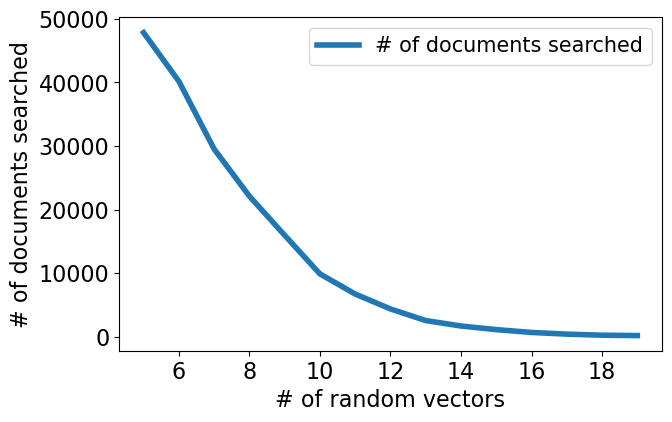

In [45]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()